¡Hola!

Mi nombre es Marcos Torres y tengo el gusto de revisar tu código el día de hoy.

Cuando vea algo notable o algún asunto en el notebook, te dejaré un comentario o un hint. Se que encontraras la mejor respuesta para resolver todos los comentarios, de no ser así, no te preocupes en futuras iteraciones dejaré comentarios y pistas más específicos.

Encontrarás comentarios en verde, amarillo o rojo como los siguientes:

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Buen trabajo. ¡Lo hiciste muy bien!
</div>

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Nota. Se puede mejorar.
</div>

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Necesitas corregirlo. Este bloque indica que se requiere una correción. El trabajo no se acepta si tiene estos bloques.
</div>

Puedes responder a mis comentarios usando estos bloques:

<div class="alert alert-block alert-info">
<b>Respuesta del estudiante.</b> <a class="tocSkip"></a>
</div>

In [1]:
#Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer

In [2]:
#cargar los archivos del data set usando a columna 'date' como índice
df_train = pd.read_csv('/datasets/gold_recovery_train.csv', index_col = 'date', parse_dates=True)
df_test = pd.read_csv('/datasets/gold_recovery_test.csv', index_col = 'date', parse_dates=True)
df_full = pd.read_csv('/datasets/gold_recovery_full.csv', index_col = 'date', parse_dates=True)


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

¡Muy bien! Usaste correctamente una celda independiente para importar las librerías y otra para leer los datos.
</div>

In [3]:
#Inspeccionamos tamaños de df
print("Tamaño del conjunto de entrenamiento:", df_train.shape)
print("Tamaño del conjunto de prueba:", df_test.shape)
print("Tamaño del conjunto completo:", df_full.shape)

Tamaño del conjunto de entrenamiento: (16860, 86)
Tamaño del conjunto de prueba: (5856, 52)
Tamaño del conjunto completo: (22716, 86)


In [4]:
# Vista previa de los datos
print("\nPrimeras filas del conjunto completo:")
print(df_full.head(5))

# Información general
print("\nInformación del conjunto completo:")
print(df_full.info())


Primeras filas del conjunto completo:
                     final.output.concentrate_ag  final.output.concentrate_pb  \
date                                                                            
2016-01-15 00:00:00                     6.055403                     9.889648   
2016-01-15 01:00:00                     6.029369                     9.968944   
2016-01-15 02:00:00                     6.055926                    10.213995   
2016-01-15 03:00:00                     6.047977                     9.977019   
2016-01-15 04:00:00                     6.148599                    10.142511   

                     final.output.concentrate_sol  \
date                                                
2016-01-15 00:00:00                      5.507324   
2016-01-15 01:00:00                      5.257781   
2016-01-15 02:00:00                      5.383759   
2016-01-15 03:00:00                      4.858634   
2016-01-15 04:00:00                      4.939416   

                     

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Buen uso de los métodos de pandas para explorar los datos.
</div>

In [5]:
#Obtenemos las columnas donde hay valores faltantes
def na_in_df(df):
    return df.isna().sum()[df.isna().sum() > 0]
print("Valores Nulos en entrenamiento:")
print(na_in_df(df_train))

print("\nValores Nulos en prueba:")
print(na_in_df(df_test))

print("\nValores Nulos en completo:")
print(na_in_df(df_full))

Valores Nulos en entrenamiento:
final.output.concentrate_ag                     72
final.output.concentrate_pb                     72
final.output.concentrate_sol                   370
final.output.concentrate_au                     71
final.output.recovery                         1521
                                              ... 
secondary_cleaner.state.floatbank5_a_level      85
secondary_cleaner.state.floatbank5_b_air        85
secondary_cleaner.state.floatbank5_b_level      84
secondary_cleaner.state.floatbank6_a_air       103
secondary_cleaner.state.floatbank6_a_level      85
Length: 85, dtype: int64

Valores Nulos en prueba:
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primar

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Bien, se exploró correctamente la precencia de los NAN a lo largo de todas las columnas de datos.
</div>

Observamos que hay varios valores faltantes el los df; por lo que para hacer el calculo de recuperación, debemos asegurarnos que las 3 columnas necesarias no tengan valores nulos.

In [6]:

columns_needed = ['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au', 'rougher.output.recovery']

print("Valores faltantes en las variables")
print(df_train[columns_needed].isna().sum())

df_train_clean = df_train.dropna(subset=columns_needed)
print()
print("Tamaño del conjunto de entrenamiento limpio con datos completos")
print(df_train_clean.shape)

Valores faltantes en las variables
rougher.output.concentrate_au      82
rougher.input.feed_au              83
rougher.output.tail_au           2249
rougher.output.recovery          2573
dtype: int64

Tamaño del conjunto de entrenamiento limpio con datos completos
(14287, 86)


In [7]:
#Realizamos el cálculo de recuperación
C = df_train_clean['rougher.output.concentrate_au']
F = df_train_clean['rougher.input.feed_au']
T = df_train_clean['rougher.output.tail_au']

recovery_calc = (C * (F - T)) / (F * (C - T)) * 100
#Comparamos el cálculo con los datos originales para obtener EAM
mae = mean_absolute_error(df_train_clean['rougher.output.recovery'], recovery_calc)
print("MAE entre el cálculo y el valor real de recuperación:", mae)

MAE entre el cálculo y el valor real de recuperación: 9.303415616264301e-15


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

¡Bien hecho! El error sale muy pequeño.
</div>

El EAM es básicamente cero; por lo que:

- La formula de recuperación se aplicó correctamente.
- Los datos originales en el df están bien calculados
- Se puede usar esta métrica como variable objetivo

  

In [8]:
#Busquemos las colunas presentes en train pero faltantes en test
train_cols = set(df_train.columns)
test_cols = set(df_test.columns)

missing_in_test = sorted(list(train_cols - test_cols))

print("Columnas faltantes en el conjunto de prueba:")
for col in missing_in_test:
    print(col)
    
print("\nNúmero total de columnas faltantes:", len(missing_in_test))

Columnas faltantes en el conjunto de prueba:
final.output.concentrate_ag
final.output.concentrate_au
final.output.concentrate_pb
final.output.concentrate_sol
final.output.recovery
final.output.tail_ag
final.output.tail_au
final.output.tail_pb
final.output.tail_sol
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_au
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_au
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
rougher.calculation.au_pb_ratio
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.sulfate_to_au_concentrate
rougher.output.concentrate_ag
rougher.output.concentrate_au
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_au
rougher.output.tail_pb
rougher.output.tail_sol
secondary_cleaner.output.tail_ag
second

Columnas faltantes en el conjunto de prueba (df_test)
Al comparar las columnas del conjunto de entrenamiento (df_train) con el conjunto de prueba (df_test), se encontraron 34 columnas que están presentes en el entrenamiento pero ausentes en la prueba. Estas columnas son principalmente de tipo output y calculation.

Esto debido a que en el entorno en donde se generan los datos, aún no se conocen. Además usar esas variables sería una fuga de datos y el modelo sería erroneo.

Para usar solo las características disponibles durante el proceso de producción, solo nos quedaremos con las columnas que están tanto en df_train como en df_test.

In [9]:
#Hacemos una funcion que nos indique las columnas tanto en test como en train
def get_real_features(train_df, test_df):
    common_cols = train_df.columns.intersection(test_df.columns)
    return list(common_cols)

real_features = get_real_features(df_train, df_test)
print('Número de variables disponibles para el modelo:', len(real_features))

Número de variables disponibles para el modelo: 52


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Buena función para obtener estos features.
</div>

In [10]:
#Revisamos valores nulos 
missing_in_test = df_test[real_features].isna().sum()
print("Valores nulos en columnas reales del conjunto de prueba:")
print(missing_in_test[missing_in_test > 0])

Valores nulos en columnas reales del conjunto de prueba:
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257
rougher.input.floatbank10_xanthate         

In [11]:
#Eliminar filas con valores nulos
df_test_clean = df_test.dropna(subset=real_features)
print("Tamaño original de df_test:", df_test.shape)
print("Tamaño limpio de df_test_clean:", df_test_clean.shape)

Tamaño original de df_test: (5856, 52)
Tamaño limpio de df_test_clean: (5383, 52)


Ya tenemos los datos limpios:

- Conjunto de entrenamiento: 14,287 filas completas

- Conjunto de prueba: 5,383 filas completas

Ambos conjuntos solo contienen las columnas reales (las que se pueden usar en producción y para la predicción).
Se eliminaron las columnas que causaban fuga de datos y las filas con valores nulos.
Ahora sí podemos pasar al análisis de datos.

In [12]:
#Comenzaremos por observar como cambia la concentración de metales (Au, Ag, Pb) en función de la etapa de purificación.
#Seleccionamos las variables que contienen las concentraciones de los 3 metales en distintas etapas
au_cols = ['rougher.input.feed_au', 'rougher.output.concentrate_au', 'final.output.concentrate_au']
ag_cols = ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'final.output.concentrate_ag']
pb_cols = ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'final.output.concentrate_pb']
#Las agruopamos en un df para analizarlas
metals_df = df_train[au_cols + ag_cols + pb_cols]

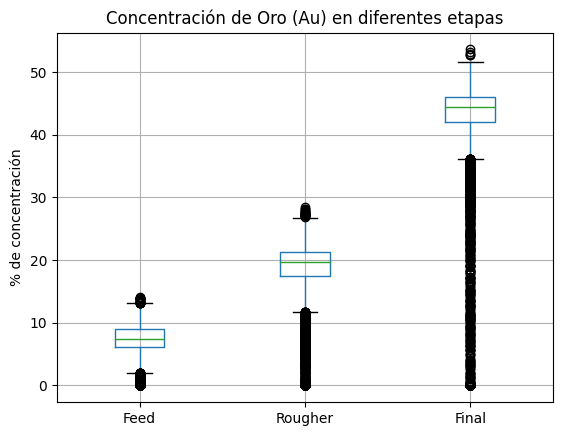

In [13]:
#Graficamos la distribución de los datos en boxplot para el oro
metals_df[au_cols].boxplot()
plt.title('Concentración de Oro (Au) en diferentes etapas')
plt.ylabel('% de concentración')
plt.xticks(ticks=[1, 2, 3], labels=['Feed', 'Rougher', 'Final'])
plt.show()

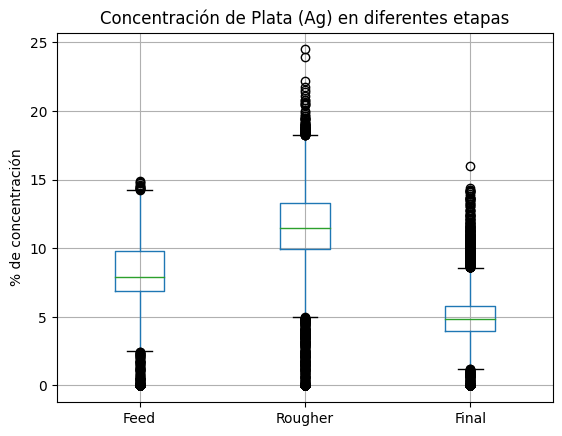

In [14]:
#Graficamos la distribución de los datos en boxplot para la plata
metals_df[ag_cols].boxplot()
plt.title('Concentración de Plata (Ag) en diferentes etapas')
plt.ylabel('% de concentración')
plt.xticks(ticks=[1, 2, 3], labels=['Feed', 'Rougher', 'Final'])
plt.show()

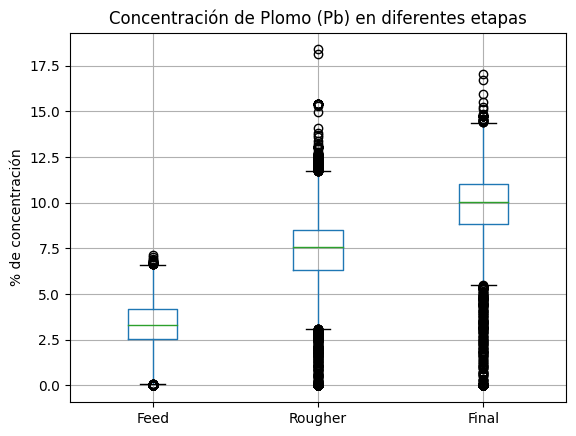

In [15]:
#Graficamos la distribución de los datos en boxplot para el plomo
metals_df[pb_cols].boxplot()
plt.title('Concentración de Plomo (Pb) en diferentes etapas')
plt.ylabel('% de concentración')
plt.xticks(ticks=[1, 2, 3], labels=['Feed', 'Rougher', 'Final'])
plt.show()

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Bien hecho, estos boxplots son muy buenos pues estan en el mismo eje y permiten comparar mejor la distribución de los datos de cada metal.
</div>

In [16]:
#Creamos una función para darnos un resumen estadístico del cambio de concentración de metales.
def resumen_estadistico(df):
    resumen = pd.DataFrame({
        'media': df.mean(),
        'mediana': df.median(),
        'varianza': df.var(),
        'desviación estándar': df.std()
    })
    resumen.index = ['Feed', 'Rougher', 'Final']
    return resumen

print("Resumen estadístico Oro")
print(resumen_estadistico(metals_df[au_cols]))
print()
print("Resumen estadístico Plata")
print(resumen_estadistico(metals_df[ag_cols]))
print()
print("Resumen estadístico Plomo")
print(resumen_estadistico(metals_df[pb_cols]))

Resumen estadístico Oro
             media    mediana    varianza  desviación estándar
Feed      7.170717   7.443530    9.012685             3.002113
Rougher  17.401541  19.644663   47.912355             6.921875
Final    39.467217  44.498874  193.689202            13.917227

Resumen estadístico Plata
             media    mediana   varianza  desviación estándar
Feed      7.832347   7.938193   9.853411             3.139014
Rougher  10.580475  11.459862  19.815759             4.451490
Final     4.716907   4.869346   4.396225             2.096718

Resumen estadístico Plomo
            media    mediana   varianza  desviación estándar
Feed     3.218931   3.297050   2.182306             1.477263
Rougher  6.880322   7.583773   8.577615             2.928757
Final    9.113559  10.065316  11.488676             3.389495


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

¡Excelente! Me gustó que definiste una función para poder calcular el resumen estadístico y así solo tienes que aplicarla e imprimirla.
</div>

    Observaciones
Oro (Au):
- La concentración aumenta significativamente en cada etapa.
Plata(Ag):
- Inicialmente incrementa la concentración en Rougher, pero al final del proceso, la concentración del mineral baja, lo cuál indica pérdidas en el proceso.
Plomo (Pb):
- La concentración aumenta a lo largo del proceso.

Las varianzas de las concentraciones son bastante elevadas en todas las etapas y para todos los metales, especialmente en la concentración final de oro (193.69). Esto se debe a la gran cantidad de valores atípicos observados, lo cual es esperable dadas las características y variabilidad inherente del proceso industrial de extracción y purificación.

In [17]:
#Proseguiremos a comparar las distribuciones del tamaño de particulas de conjunto de entrenamiento y prueba, para evaluar si este último es representativo.
#Debido a que queremos el tamaño de las particulas de la alimentación usaremos la variable rougher.input.feed_size. 
#Comparamos las estadísticas
print("Media - Train:", df_train['rougher.input.feed_size'].mean())
print("Media - Test :", df_test['rougher.input.feed_size'].mean())

print("Desviación estándar - Train:", df_train['rougher.input.feed_size'].std())
print("Desviación estándar - Test :", df_test['rougher.input.feed_size'].std())


Media - Train: 58.67644376412422
Media - Test : 55.93753506406803
Desviación estándar - Train: 23.922590769012587
Desviación estándar - Test : 22.72425379456238


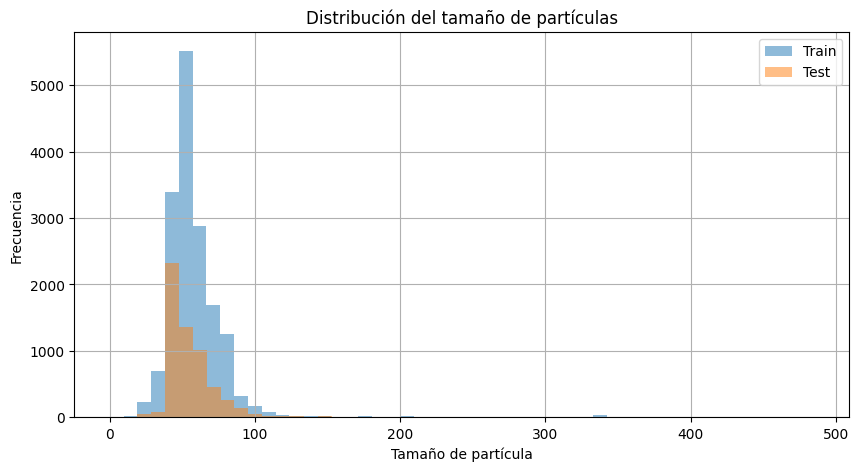

In [18]:
#Comparamos ambos conjuntos con un histograma
plt.figure(figsize=(10,5))


df_train['rougher.input.feed_size'].hist(alpha=0.5, bins=50, label='Train')
df_test['rougher.input.feed_size'].hist(alpha=0.5, bins=50, label='Test')

plt.title('Distribución del tamaño de partículas')
plt.xlabel('Tamaño de partícula')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

El histograma es correcto, pero sería bueno usar en lugar frecuencia la densidad, de esta manera no importa el tamaño de cada uno de los conjuntos a comparar.
</div>

La distribución del tamaño de particulas en ambos conjuntos es similar tanto visual como estadísticamente.
El conjunto de prueba es representativo para evaluar el modelo.


In [19]:
#Consideraremos las concentraciones totales de cada material en todas las fases del proceso para observar valores anormales y considerar su permnencia en el data set
#Creamos listas de las concentraciones de oro, plata, plomo y residuos solidos por etapa
feed_cols = ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol']
rougher_cols = ['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol']
final_cols = ['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol']
#Calculamos la suma todal de concentraciones 
df_train['feed_sum'] = df_train[feed_cols].sum(axis=1)
df_train['rougher_sum'] = df_train[rougher_cols].sum(axis=1)
df_train['final_sum'] = df_train[final_cols].sum(axis=1)

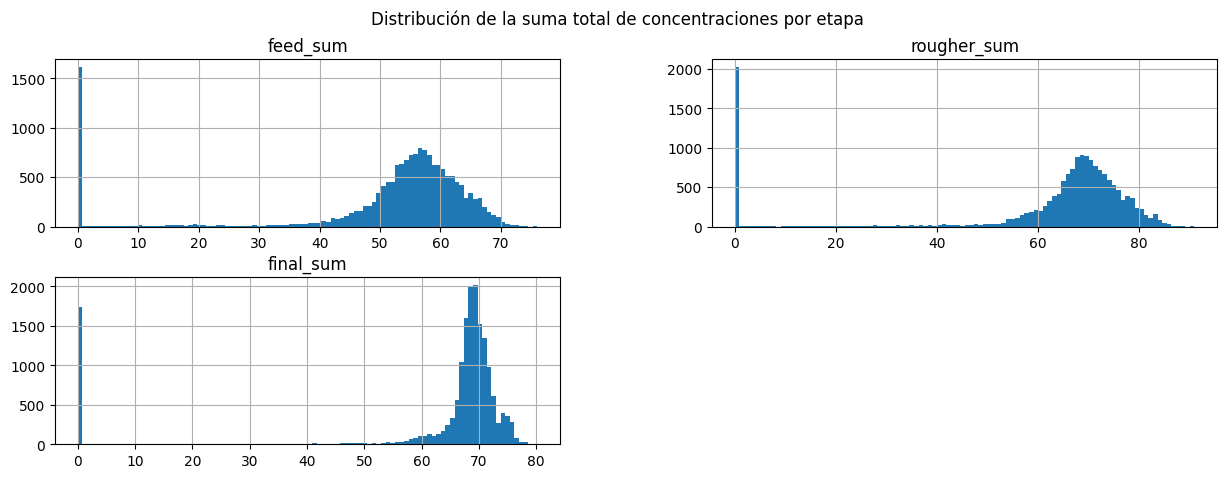

In [20]:
#Graficamos la distribución de los resultados en un histograma
df_train[['feed_sum', 'rougher_sum', 'final_sum']].hist(bins=100, figsize=(15,5))
plt.suptitle("Distribución de la suma total de concentraciones por etapa")
plt.show()

In [21]:
#Verificamos valores extremos para cada proceso
print("Materia prima")
print("Valores muy bajos en feed_sum:", (df_train['feed_sum'] < 1).sum())
print("Valores muy altos en feed_sum:", (df_train['feed_sum'] > 99).sum())
print()
print("Concentrado rougher")
print("Valores muy bajos en rougher_sum:", (df_train['rougher_sum'] < 1).sum())
print("Valores muy altos en rougher_sum:", (df_train['rougher_sum'] > 99).sum())
print()
print("Concentrado final")
print("Valores muy bajos en final_sum:", (df_train['final_sum'] < 1).sum())
print("Valores muy altos en final_sum:", (df_train['final_sum'] > 99).sum())


Materia prima
Valores muy bajos en feed_sum: 1616
Valores muy altos en feed_sum: 0

Concentrado rougher
Valores muy bajos en rougher_sum: 2022
Valores muy altos en rougher_sum: 0

Concentrado final
Valores muy bajos en final_sum: 1735
Valores muy altos en final_sum: 0


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Buena comparación de los datos.
</div>

Gracias a los historiogramas nos dimos cuenta que en la distribución de la suma total de concentraciones, se apreciaban bastantes valores atípicos, donde dichos resultados no son realistas al acercarse al 0%. Estas filas al ser valores anormales deben eliminarse; pues lo más seguro es que sean resultado de errores de medición o registros incompletos.

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Buenos comentarios, los histogramas resultaron de utilidad para encontrar estas diferencias.
</div>

In [22]:
# Elimina columnas si ya existen en df_train_clean para evitar duplicados en el join
df_train_clean = df_train_clean.drop(columns=['feed_sum', 'rougher_sum', 'final_sum'], errors='ignore')
#Antes debemos unir 'feed_sum', 'rougher_sum' y 'final_sum' con df_train_clean que no tiene valores nulos
sumas = df_train[['feed_sum', 'rougher_sum', 'final_sum']]
df_train_clean = df_train_clean.join(sumas)
#Creamos un data set para el conjunto de entrenamiento sin valores faltantes ni anormales.
df_train_final = df_train_clean[
    (df_train_clean['feed_sum'] >= 1) &
    (df_train_clean['rougher_sum'] >= 1) &
    (df_train_clean['final_sum'] >= 1)
]

print("Tamaño del df_train final tras eliminar valores anómalos:", df_train_final.shape)


Tamaño del df_train final tras eliminar valores anómalos: (13857, 89)


In [23]:
#Redefinimos real_features ahora usando los conjuntos limpios y finales 
real_features = get_real_features(df_train_final, df_test_clean)


In [24]:
#Creamos una función para calcular el valor de sMAPE (error medio absoluto porcentual simétrico)
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_pred) + np.abs(y_true)) / 2
    smape_val = numerator / denominator
    return np.mean(smape_val) * 100
#Adaptamos el score de sMAPE debido a que es un indicador de error, marcamos que greater_is_better=False
smape_scorer = make_scorer(smape, greater_is_better=False)

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

La función del smape es acertada.
</div>

In [25]:
#Preparamos datos, utilizamos la lista real_features anteriormente encontrada que contiene todas las variables que aparecen en los ocnjuntos train y test
X = df_train_final[real_features]
y_rougher = df_train_final['rougher.output.recovery']
y_final = df_train_final['final.output.recovery']
#Para evitar que se filtren datos Nan
#Juntamos X y los dos y en un mismo DataFrame
df_model = X.copy()
df_model['y_rougher'] = y_rougher
df_model['y_final'] = y_final

# Eliminamos cualquier fila con valores NaN
df_model_clean = df_model.dropna()

# Separamos de nuevo X, y_rougher y y_final limpios
X_clean = df_model_clean.drop(columns=['y_rougher', 'y_final'])
y_rougher_clean = df_model_clean['y_rougher']
y_final_clean = df_model_clean['y_final']

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

¡Muy bien! Los datos se dividieron correctamente en entrenamiento y prueba.
</div>

In [26]:
# Diagnóstico rápido
print("¿NaNs en X?", X_clean.isna().sum().sum())
print("¿NaNs en y_rougher?", y_rougher_clean.isna().sum())
print("¿NaNs en y_final?", y_final_clean.isna().sum())
print("Tamaño del df_model_clean tras eliminar valores anómalos:", df_model_clean.shape)

¿NaNs en X? 0
¿NaNs en y_rougher? 0
¿NaNs en y_final? 0
Tamaño del df_model_clean tras eliminar valores anómalos: (12429, 54)


In [27]:
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=30, random_state=1, n_jobs=-1)  # n_jobs acelera muchísimo
}
for name, model in models.items():
    score_rougher = cross_val_score(model, X_clean, y_rougher_clean, cv=5, scoring=smape_scorer)
    score_final = cross_val_score(model, X_clean, y_final_clean, cv=5, scoring=smape_scorer)

    smape_rougher = -score_rougher.mean()
    smape_final = -score_final.mean()
    smape_total = 0.25 * smape_rougher + 0.75 * smape_final

    print(f"\nModelo: {name}")
    print(f"sMAPE Rougher: {smape_rougher:.2f}")
    print(f"sMAPE Final: {smape_final:.2f}")
    print(f"sMAPE Total: {smape_total:.2f}")


Modelo: LinearRegression
sMAPE Rougher: 6.84
sMAPE Final: 10.17
sMAPE Total: 9.34

Modelo: RandomForest
sMAPE Rougher: 6.38
sMAPE Final: 10.13
sMAPE Total: 9.19


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

¡Perfecto! Con esto obtuviste una comparación muy buena del sMAPE para ambos modelos.
</div>

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Sería bueno que al entrenar el RandomForest probaras con otros hiperparámetros para encontrar el mejor modelo, pero esto se puede practicar en otros proyectos.
</div>

    Resultados en el conjunto de entrenamiento:
    
    -A pesar de haber eliminado valores atípicos, la alta varianza de los datos refleja la complejidad del proceso, por lo que los resultados de sMAPE obtenidos por ambos modelos se consideran aceptables.
    
    -El modelo Random Forest logra una ligera mejora en los valores de sMAPE en comparación con Linear Regression.
    
    -Se observan mejores métricas de sMAPE en el proceso Rougher, ya que el proceso Final es más complejo y propenso a variaciones. Esto se refleja en un sMAPE Total más alto.

In [28]:
#Pasamos a probar el mejor modelo con el conjunto de prueba
#Preparamos el conjunto de prueba
X_test = df_test_clean[real_features]

#Extraemos los valores verdaderos de y_rougher y y_final para poder evaluar el modelo con sMAPE correctamente
df_target = df_full.loc[df_test_clean.index, ['rougher.output.recovery', 'final.output.recovery']]
df_test_full = df_test_clean.join(df_target)

#Declaramos el mejor modelo para ambos procesos
best_model_rougher = RandomForestRegressor(n_estimators=30, random_state=1, n_jobs=-1)
best_model_final = RandomForestRegressor(n_estimators=30, random_state=1, n_jobs=-1)

#Entrenamos el modelo
best_model_rougher.fit(X_clean, y_rougher_clean)
best_model_final.fit(X_clean, y_final_clean)

#Hacemos las predicciones
y_pred_rougher = best_model_rougher.predict(X_test)
y_pred_final = best_model_final.predict(X_test)

#Obtenemos los valores reales para calcular sMAPE del conjunto de prueba
y_true_rougher = df_test_full['rougher.output.recovery']
y_true_final = df_test_full['final.output.recovery']

#Calculamos sMAPE
smape_r = smape(y_true_rougher, y_pred_rougher)
smape_f = smape(y_true_final, y_pred_final)
smape_total = 0.25 * smape_r + 0.75 * smape_f

print(f"sMAPE Rougher (Test): {smape_r:.2f}")
print(f"sMAPE Final (Test): {smape_f:.2f}")
print(f"sMAPE Total (Test): {smape_total:.2f}")

sMAPE Rougher (Test): 8.05
sMAPE Final (Test): 9.79
sMAPE Total (Test): 9.35


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Bien, obtuviste un modelo con un buen rendimiento de acuerdo al SMAPE.
</div>

## Conclusiónes:

El modelo RandomForestRegressor, entrenado con datos depurados y evaluado usando métodos de validación cruzada mostró un buen rendimiento en el conjunto de prueba con un sMAPE en el proceso Rougher de 8.05, un sMAPE en el proceso final de 9.79, obteniendo un sMAPE total de 9.35.

Esto le da al modelo la capacidad de predecir con un error aceptable el porcentaje de recuperación durante los procesos de obtención de oro en la empresa para cada fase, dependiendo de las variables físico-químicas del proceso como el tamaño de partícula, la concentración de metales (Au, Ag, Pb), y la proporción de sólidos en las distintas etapas de tratamiento.

Se considera este un proceso complejo, cuyos resultados presentan varianzas elevadas y valores atípicos, por lo que obtener una métrica sMAPE Total por debajo del 10% valida la solidez del modelo y su utilidad práctica en un entorno industrial.


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Buenas conclusiones, basadas en lo realizado a lo largo de todo el proyecto.
</div>

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

¡Hola!

Te quiero felicitar por tu proyecto, está bastante completo y bien realizado. 

Solo realicé unos comentarios opcionales de color amarillo, pero no son necesarios para aprobar el proyecto. Te deseo mucho éxito en los siguientes sprints.

Saludos, Marcos.
</div>